In [1]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with miniai

This is an exploration of notebook 15 by Jeremy.

## Imports

In [2]:
!pip install torcheval

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
dt = dls.train
xb,yb = next(iter(dt))

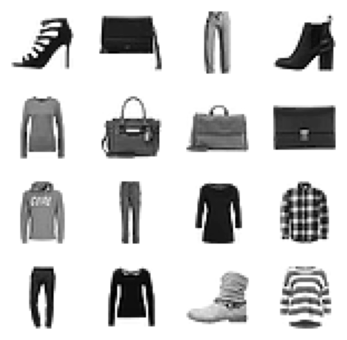

In [8]:
show_images(xb[:16], imsize=1.5)

In [9]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

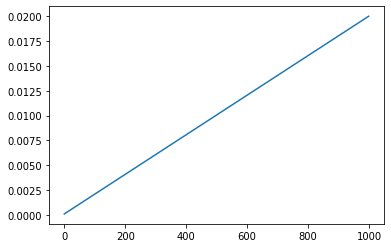

In [10]:
plt.plot(beta);

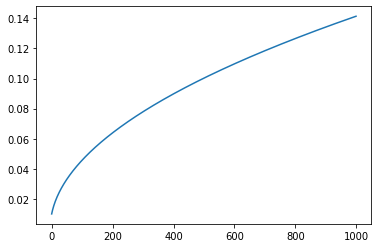

In [11]:
plt.plot(sigma);

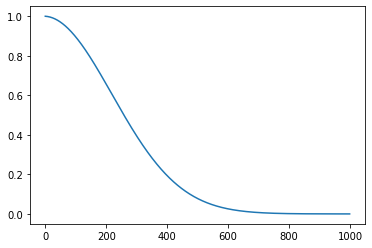

In [12]:
plt.plot(alphabar);

In [13]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [14]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([229, 414, 172, 952, 616, 311, 201, 977, 191, 436, 505, 487, 901, 487,
        569, 412, 289, 260, 514, 739, 269,  33, 329, 869, 791])

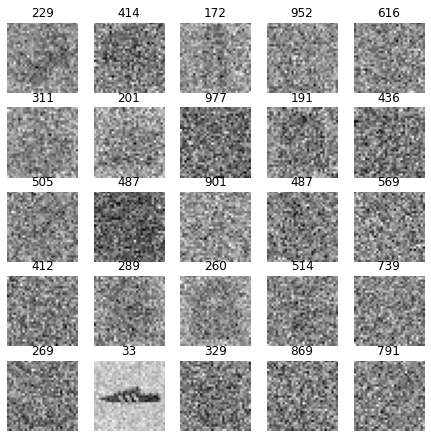

In [15]:
titles = fc.map_ex(t, '{}') # stringify the elements of the t tensor using the format string thing
show_images(xt, imsize=1.5, titles=titles)

As we saw in notebook 15, t above 200 is just noise.

In [16]:
fc.map_ex(t, '{}')

['229',
 '414',
 '172',
 '952',
 '616',
 '311',
 '201',
 '977',
 '191',
 '436',
 '505',
 '487',
 '901',
 '487',
 '569',
 '412',
 '289',
 '260',
 '514',
 '739',
 '269',
 '33',
 '329',
 '869',
 '791']

## Training

In [4]:
from huggingface_hub import notebook_login
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [4]:
from diffusers import UNet2DModel

In [18]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [19]:
class DDPMCB(Callback): # now we're inheriting from Callback instead of TrainCB
                        # so how are we going to do the same trick as in the predict in notebook 15?
                        # => we can override the forward function of the model (see below)
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [20]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [21]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

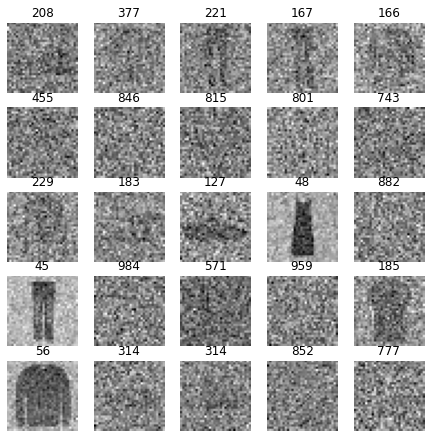

In [22]:
# they use group norm in the Unet model
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss()) # we can use either TrainCB or TrainLearner 
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()]) # we can use the train=False + SingleBatchCB trick to show the first batch
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [23]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [24]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [25]:
# oddly enough, even the experts from the paper or at hugging face were not initializing anything 
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_() # zero out every second convolutional layer, 
                                        # so that the non-id paths do nothing at first, 
                                        # which is the basic idea of batchnorm which we removed at some point
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight) # use orthogonal weights for the downsamplers 

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_() # same as above 
    # also zero out the weights of the last layer so it is going to start by predicting zero as the noise, which can't hurt 
    model.conv_out.weight.data.zero_()

In [26]:
init_ddpm(model)

In [27]:
opt_func = partial(optim.Adam, eps=1e-5) # replace the normal optimizer with one that 
                                         # has an eps of 1e-5 (the default is 1e-8). 
                                         # Until we did that, somewhere around the middle
                                         # of 1cycle training it would explode 

In [28]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.027,0,eval
0.023,1,train
0.024,1,eval
0.021,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.017,4,eval


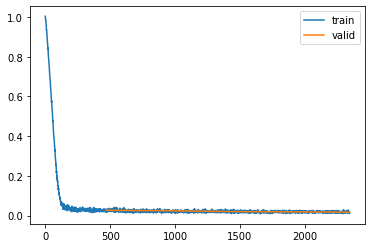

In [29]:
learn.fit(epochs)

In [30]:
mdl_path = Path('models')

In [31]:
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [32]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

In [ ]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

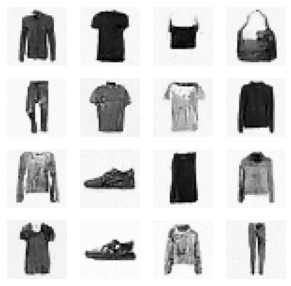

In [ ]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision

GPUs are much much much faster at doing 16bit floating point values than 32bit. On the other hand they are not able to represent a wide range of numbers with great precision compared to 32bit, so they're more difficult to use. You can't convert everything to 16bit because then you don't have enough precision to calculate the gradients and everything, so we use mixed precision. We use 32bit for things where we need 32bits and 16bit everywhere else.

Also, we are also going to show how to train the model without any callback at all: we can noisify inside the collation function.

With mixed precision, we really need to keep the GPU busy, that's why we've increased the batch size by 4:

In [ ]:
bs = 512

In [ ]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [33]:
default_collate

<function torch.utils.data._utils.collate.default_collate(batch)>

In [35]:
# use default_collate on the batch then 
# take the image key of the resulting  dict (because  xl = 'image')
# in the end this is the same as the before_batch method from notebook 15
# because before_batch is operating on the result of default_collate
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

Instead of using DataLoaders.from_dd we can just use DataLoaders because its `__init__` function is expecting two dls, one for training and one for validation

In [34]:
DataLoaders??

Init signature: DataLoaders(*dls)
Docstring:      <no docstring>
Source:        
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
File:           /notebooks/course22p2/nbs/miniai/datasets.py
Type:           type
Subclasses:     


In [36]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

With all that we don't the DDPM callback anymore (not required, just to flex our muscles).

As we can see from the pytorch doc, autocast is used in a context manager:

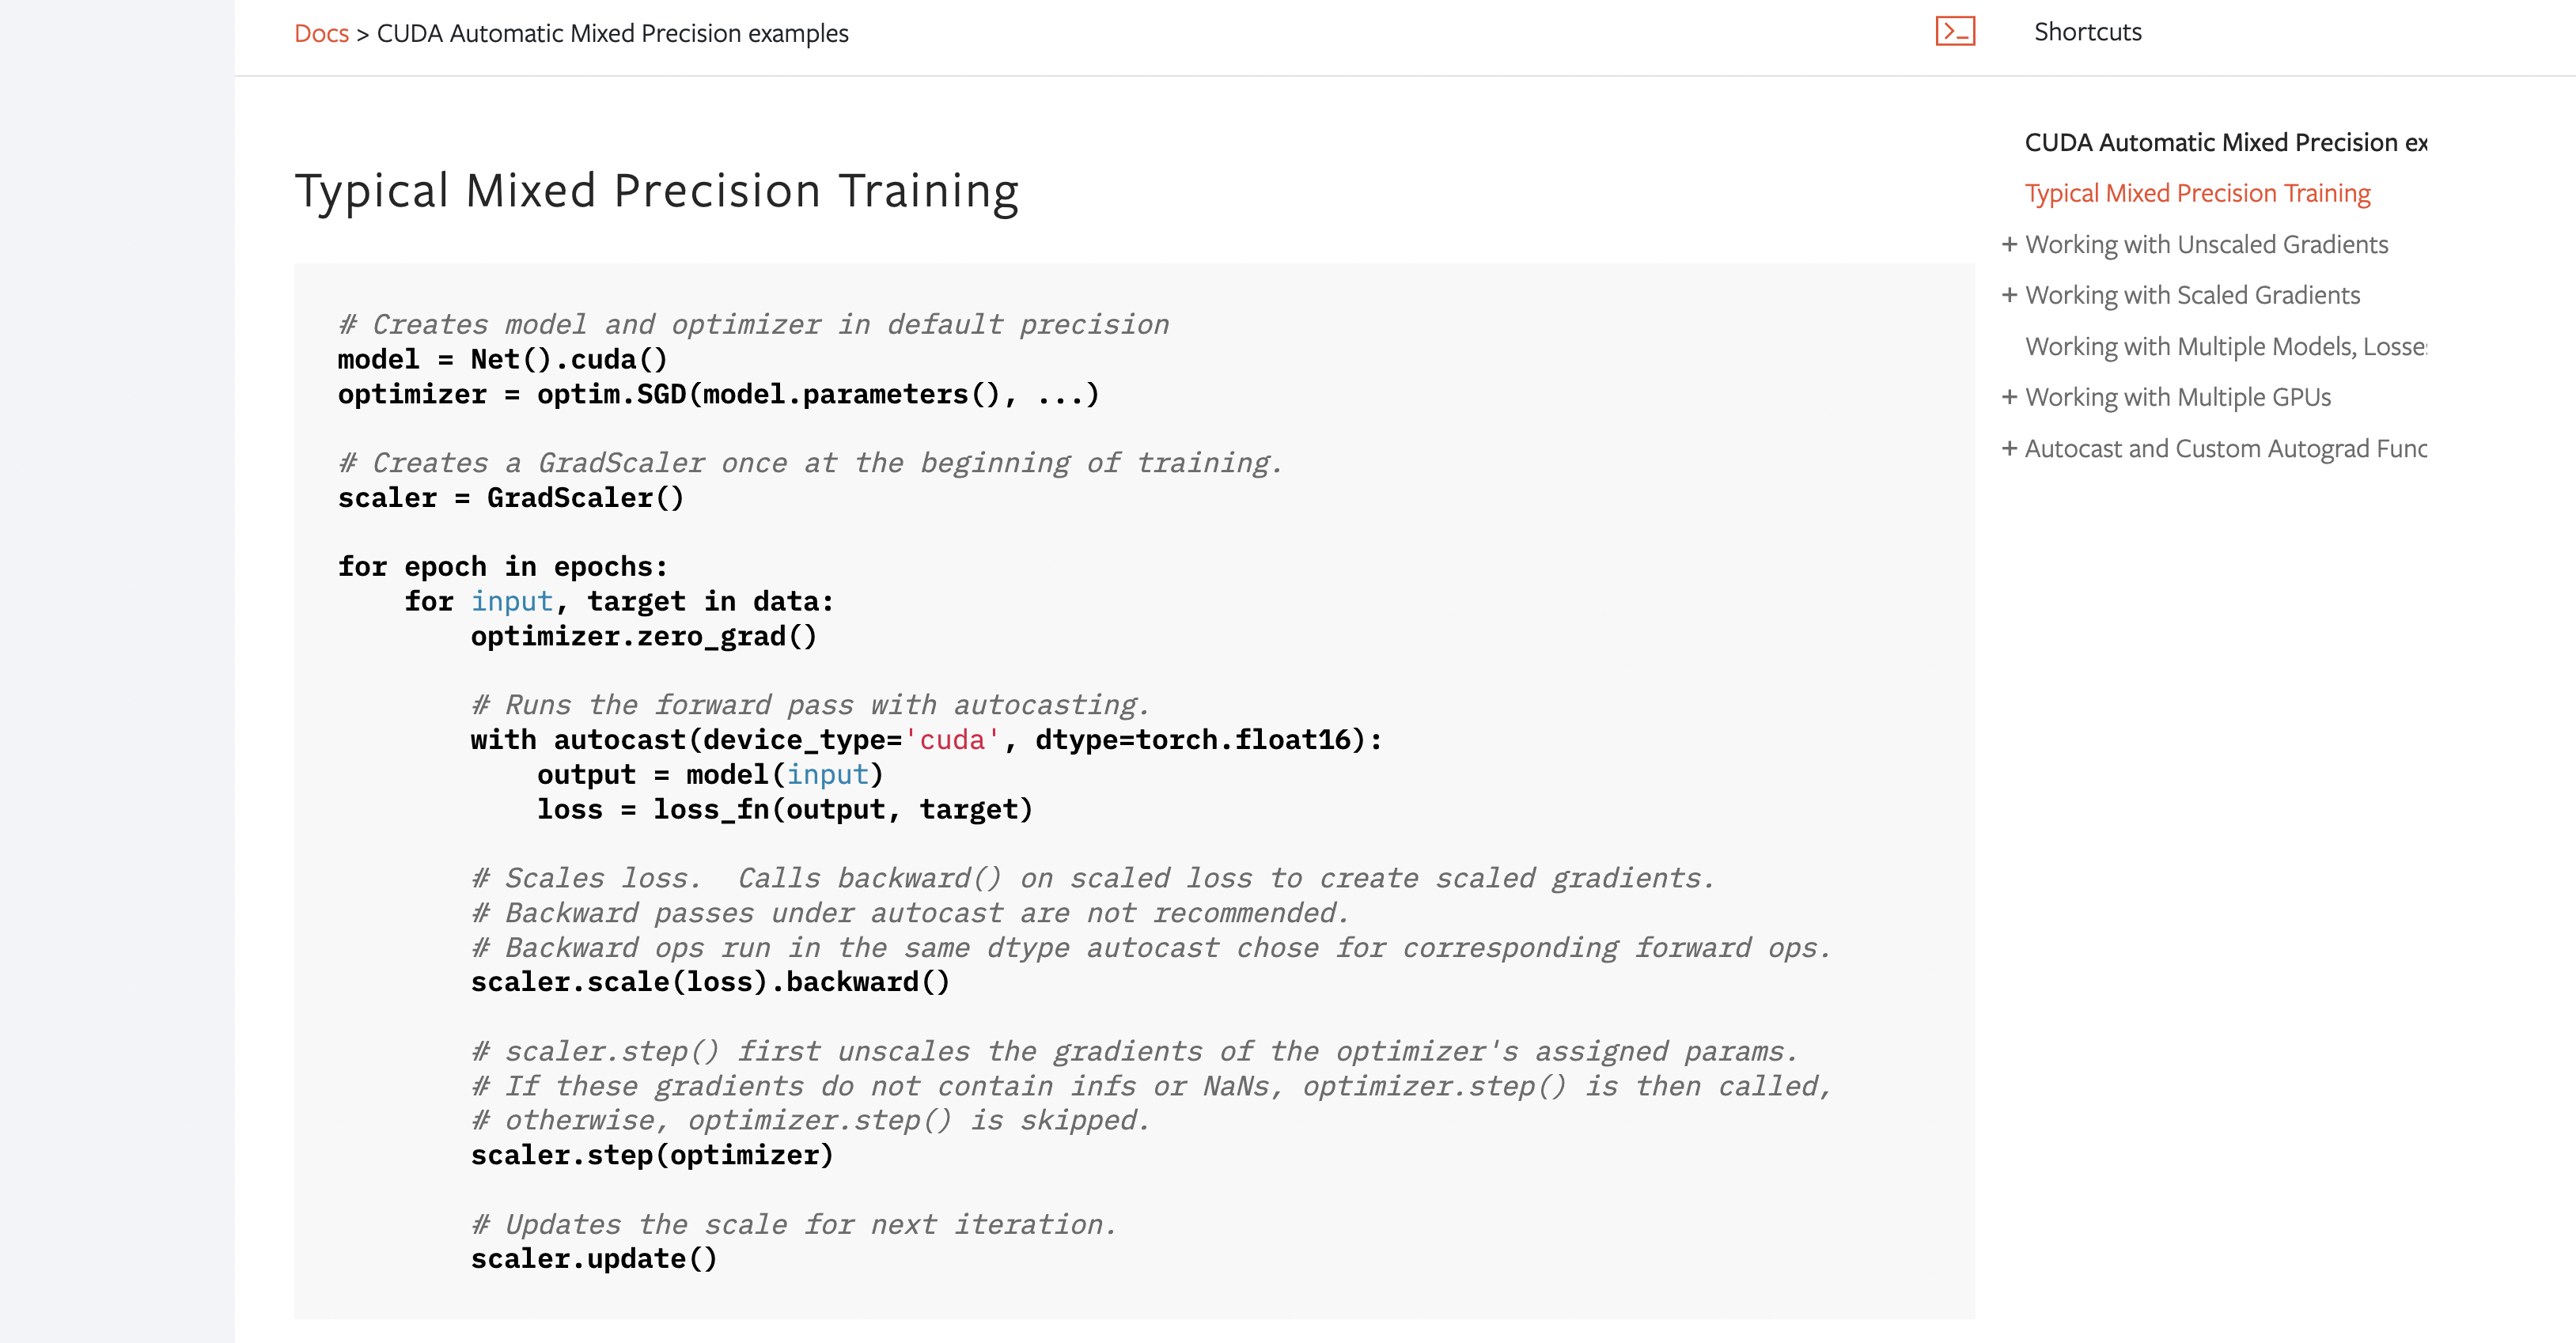

Therefore we need to call `__enter__` before the batch begins, and `__exit__` after the loss:

And, as we can see from the pytorch docs, instead of calling `learn.loss.backward()` we need to call scaler.scale(learn.loss).backward(), same idea for the optimizer

In [ ]:
#|export
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt) 
        self.scaler.update()

With this callback, we can add mixed precision to anything.

`MixedPrecision` inherits from `TrainCB` so we need a normal `Learner`, not a `TrainLearner`

Increasing the batch size by 4 means each epoch is going to have 4 times less opportunities to learn, so if we don't do anything, the results are going to be worse (we are doing mixed precision just to speed things up). Therefore we increase the lr up to 1e-2 and we increase the epochs from 5 to 8.

In [ ]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

Even though there are more epochs, this trains about twice as fast and end up with the same loss:

loss,epoch,train
0.265,0,train
0.033,0,eval
0.030,1,train
0.025,1,eval
0.024,2,train
0.023,2,eval
0.022,3,train
0.022,3,eval
0.020,4,train
0.020,4,eval


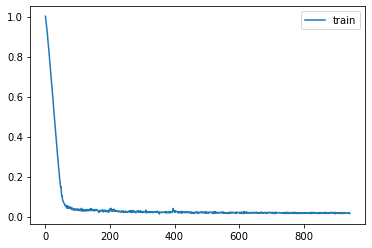

In [ ]:
learn.fit(epochs)

In [ ]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, n_steps)

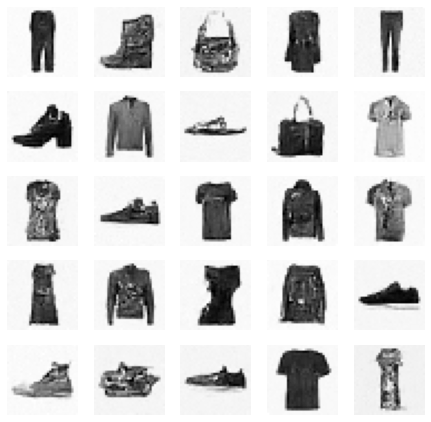

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
torch.save(learn.model, 'models/fashion_ddpm_mp.pkl')

But we actually don't need the MixedPrecision callback since we have the Accelerate library.

## Accelerate

`pip install accelerate` before running this section.

In [ ]:
#|export
from accelerate import Accelerator

In [ ]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)

    def backward(self, learn): self.acc.backward(learn.loss) # we also need to wrap the loss, which is why we inherited from TrainCB 

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε # instead of returning a tuple of tuples, we just return a tuple, which is less tricky
                               # And also we don't want to overide the UNet model

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

To avoid overiding the model we use n_inp which is expected from the `__init__` method from the TrainCB callback:

In [38]:
TrainCB??

Init signature: TrainCB(n_inp=1)
Docstring:      <no docstring>
Source:        
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
File:           /notebooks/course22p2/nbs/miniai/learner.py
Type:           type
Subclasses:     


In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.268,0,train
0.035,0,eval
0.029,1,train
0.027,1,eval
0.024,2,train
0.022,2,eval
0.021,3,train
0.024,3,eval
0.020,4,train
0.020,4,eval


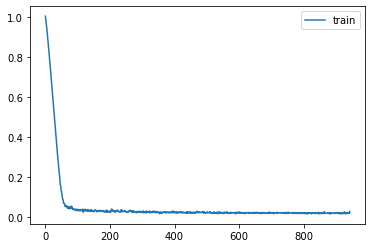

In [ ]:
learn.fit(epochs)

## A sneaky trick

If our data loading or transformation process is slow and it's difficult to keep our GPUs busy (on Kaggle we have two GPUs but only two CPUs), here is a trick:

In [39]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [40]:
dls.train = MultDL(dls.train)

So if we wrap our dls with an instance of this class, when we loop through our dls,  it is going to spit out the batch twice in the default case. So every epoch is going to be twice as long, but it is going to load and transform the data once per epoch but it is going to give 2 epochs worth of updates. This is still useful because we get the batch once and it gets us towards one direction in the weights space, then we use the batch a second time to update the weight yet in another useful direction.

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()